## **1. Setup the environment**
We will first download and install all the neccessary libraries, modules and packages.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install catboost
!pip install pmdarima
!pip install joypy
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.4 MB/s eta 0:00:00


In [4]:
# Data Manipulation
import numpy as np
import pandas as pd
# import pandas_profiling

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Track time
import time
import datetime
import calendar


# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor


# Time Series Models
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


# Statistics
import scipy.stats
import warnings
from tqdm import tqdm

# Set Options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('expand_frame_repr', False)
%matplotlib inline
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 1. Load Datasets

In [5]:
air_reserve=pd.read_csv("/content/drive/MyDrive/Data/air_reserve.csv")
air_store_info=pd.read_csv("/content/drive/MyDrive/Data/air_store_info.csv")
air_visit_data=pd.read_csv("/content/drive/MyDrive/Data/air_visit_data.csv")
hpg_reserve=pd.read_csv("/content/drive/MyDrive/Data/hpg_reserve.csv")
hpg_store_info=pd.read_csv("/content/drive/MyDrive/Data/hpg_store_info.csv")
store_id_relation=pd.read_csv("/content/drive/MyDrive/Data/store_id_relation.csv")
sample_submission=pd.read_csv("/content/drive/MyDrive/Data/sample_submission.csv")
date_info=pd.read_csv("/content/drive/MyDrive/Data/date_info.csv")

In [6]:
#Checking the shape/dimension of the datasets
for i in [air_reserve,air_store_info,air_visit_data,hpg_reserve,hpg_store_info,store_id_relation,sample_submission,date_info]:
  print(i.shape)

(92378, 4)
(829, 5)
(252108, 3)
(2000320, 4)
(4690, 5)
(150, 2)
(32019, 2)
(517, 3)


In [7]:
#Loading first five observations of each datasets
for i in [air_reserve,air_store_info,air_visit_data,hpg_reserve,hpg_store_info,store_id_relation,sample_submission,date_info]:
  print(i.head())

           air_store_id       visit_datetime     reserve_datetime  reserve_visitors
0  air_877f79706adbfb06  2016-01-01 19:00:00  2016-01-01 16:00:00                 1
1  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00                 3
2  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00                 6
3  air_877f79706adbfb06  2016-01-01 20:00:00  2016-01-01 16:00:00                 2
4  air_db80363d35f10926  2016-01-01 20:00:00  2016-01-01 01:00:00                 5
           air_store_id  air_genre_name                 air_area_name   latitude   longitude
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124  135.197853
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124  135.197853
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124  135.197853
3  air_a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124  135.197853
4  air_83db5aff8f50478e  Italia

##**2. Understand Data**
Creating a function understand(dataset) to extract the dimensions and simple stattistics of the datasets to get the bird's eye view.

In [8]:
def Understand_df(df):
  # Printing the shape of the datset.
  print(f"The shape of the dataset is {df.shape}")

  #Printing first 5 observations of dataset to undeerstand it's variable(columns)
  print(f"The first 5 observations are {df.head()}")

  #Printing the basic summary of the dataset.
  print(f"The basic summary of the dataset are {df.describe()}")

  #Statitics for the given datasets.
  stats=[]
  for i in df.columns:
    stats.append((i,df[i].nunique(),df[i].isnull().sum()*100/df.shape[0],
                  df[i].value_counts(normalize=True,dropna=False).values[0]*100,
                  df[i].dtype))
  stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values','Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
  print("Statistics of the dataset are \n",stats_df.sort_values('Percentage of missing values', ascending=False), "\n\n")

## 2.1 Store Info Data(AIR & HPG)


In [9]:
Understand_df(air_store_info) # AIR Store info

The shape of the dataset is (829, 5)
The first 5 observations are            air_store_id  air_genre_name                 air_area_name   latitude   longitude
0  air_0f0cdeee6c9bf3d7  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124  135.197853
1  air_7cc17a324ae5c7dc  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124  135.197853
2  air_fee8dcf4d619598e  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124  135.197853
3  air_a17f0778617c76e2  Italian/French  Hyōgo-ken Kōbe-shi Kumoidōri  34.695124  135.197853
4  air_83db5aff8f50478e  Italian/French  Tōkyō-to Minato-ku Shibakōen  35.658068  139.751599
The basic summary of the dataset are          latitude   longitude
count  829.000000  829.000000
mean    35.647042  137.415311
std      2.084659    3.650971
min     33.211967  130.195555
25%     34.695124  135.341564
50%     35.658068  139.685474
75%     35.694003  139.751599
max     44.020632  144.273398
Statistics of the dataset are 
           Feature  Unique_values  Per

In [10]:
Understand_df(hpg_store_info) # HPG Store info

The shape of the dataset is (4690, 5)
The first 5 observations are            hpg_store_id  hpg_genre_name                  hpg_area_name   latitude   longitude
0  hpg_6622b62385aec8bf  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675  139.668221
1  hpg_e9e068dd49c5fa00  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675  139.668221
2  hpg_2976f7acb4b3a3bc  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675  139.668221
3  hpg_e51a522e098f024c  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675  139.668221
4  hpg_e3d0e1519894f275  Japanese style  Tōkyō-to Setagaya-ku Taishidō  35.643675  139.668221
The basic summary of the dataset are           latitude    longitude
count  4690.000000  4690.000000
mean     35.810261   137.675816
std       2.138755     3.197233
min      33.311645   130.339313
25%      34.692109   135.498859
50%      35.659214   139.495733
75%      35.703381   139.737998
max      43.774846   143.714585
Statistics of the dataset are 
           Fe

*   There are 829 stores of AIR type while there are 4690  
     HPG.
*   There are no missing values of both the stores.

   




## 2.2 Visit Data

In [11]:
Understand_df(air_visit_data) # AIR Visit Data

The shape of the dataset is (252108, 3)
The first 5 observations are            air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6
The basic summary of the dataset are             visitors
count  252108.000000
mean       20.973761
std        16.757007
min         1.000000
25%         9.000000
50%        17.000000
75%        29.000000
max       877.000000
Statistics of the dataset are 
         Feature  Unique_values  Percentage of missing values  Percentage of values in the biggest category    type
0  air_store_id            829                           0.0                                      0.189205  object
1    visit_date            478                           0.0                                      0.316928  object
2      visitors            204                      

In [12]:
# Finding the days for which the AIR store operated
min=air_visit_data.visit_date.min()
max=air_visit_data.visit_date.max()
print(min,max)
print("The days of operations for the AIR type is", (pd.to_datetime(max)-pd.to_datetime(min)).days)

2016-01-01 2017-04-22
The days of operations for the AIR type is 477


In [13]:
# Checking if there are unique store id present in air_store_info & air_visit_data
np.setdiff1d(air_visit_data["air_store_id"], air_store_info["air_store_id"])

array([], dtype=object)



*   There are 829 stores of AIR type.
*   There are no missing values present.
*   The AIR type restraunt had catered about 252k serving   
     in 477 days.  
*   The info in store visit data aligns with store info.



## 2.3 Reservation Data

In [14]:
Understand_df(air_reserve)

The shape of the dataset is (92378, 4)
The first 5 observations are            air_store_id       visit_datetime     reserve_datetime  reserve_visitors
0  air_877f79706adbfb06  2016-01-01 19:00:00  2016-01-01 16:00:00                 1
1  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00                 3
2  air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00                 6
3  air_877f79706adbfb06  2016-01-01 20:00:00  2016-01-01 16:00:00                 2
4  air_db80363d35f10926  2016-01-01 20:00:00  2016-01-01 01:00:00                 5
The basic summary of the dataset are        reserve_visitors
count      92378.000000
mean           4.481749
std            4.919669
min            1.000000
25%            2.000000
50%            3.000000
75%            5.000000
max          100.000000
Statistics of the dataset are 
             Feature  Unique_values  Percentage of missing values  Percentage of values in the biggest category    type
0      air_store_id     

In [15]:
# Finding the visits for the reservations of the AIR store
min=air_reserve.visit_datetime.min()
max=air_reserve.visit_datetime.max()
print(min,max)
print("The number of visits for the AIR type is", (pd.to_datetime(max)-pd.to_datetime(min)).days)

2016-01-01 19:00:00 2017-05-31 21:00:00
The number of visits for the AIR type is 516


In [16]:
# Finding the reservations for the AIR store
min=air_reserve.reserve_datetime.min()
max=air_reserve.reserve_datetime.max()
print(min,max)
print("The number of reservations for the AIR type is", (pd.to_datetime(max)-pd.to_datetime(min)).days)

2016-01-01 01:00:00 2017-04-22 23:00:00
The number of reservations for the AIR type is 477


In [17]:
# Stores present in air reserve data not present in air store info
np.setdiff1d(air_reserve["air_store_id"], air_store_info["air_store_id"])

array([], dtype=object)

In [18]:
Understand_df(hpg_reserve)

The shape of the dataset is (2000320, 4)
The first 5 observations are            hpg_store_id       visit_datetime     reserve_datetime  reserve_visitors
0  hpg_c63f6f42e088e50f  2016-01-01 11:00:00  2016-01-01 09:00:00                 1
1  hpg_dac72789163a3f47  2016-01-01 13:00:00  2016-01-01 06:00:00                 3
2  hpg_c8e24dcf51ca1eb5  2016-01-01 16:00:00  2016-01-01 14:00:00                 2
3  hpg_24bb207e5fd49d4a  2016-01-01 17:00:00  2016-01-01 11:00:00                 5
4  hpg_25291c542ebb3bc2  2016-01-01 17:00:00  2016-01-01 03:00:00                13
The basic summary of the dataset are        reserve_visitors
count      2.000320e+06
mean       5.073785e+00
std        5.416172e+00
min        1.000000e+00
25%        2.000000e+00
50%        3.000000e+00
75%        6.000000e+00
max        1.000000e+02
Statistics of the dataset are 
             Feature  Unique_values  Percentage of missing values  Percentage of values in the biggest category    type
0      hpg_store_id   

In [19]:
#Checking for any unique store in the hpg_reserve and hpg_store_info
print(np.setdiff1d(hpg_reserve["hpg_store_id"],hpg_store_info["hpg_store_id"]))
print(len(np.setdiff1d(hpg_reserve["hpg_store_id"],hpg_store_info["hpg_store_id"])))

['hpg_001112ef76b9802c' 'hpg_0023b061a9f3279a' 'hpg_0025a7a2ddb76a01' ...
 'hpg_fffa3b36bc525136' 'hpg_fffa98e9f58176a9' 'hpg_fffc097dce87af3e']
8635




*   There are some extra visits in AIR type by non reserved customers(516-477=39)
*   There are no unique store id in AIR type but there are about 8635 new store id's for the HPG type.



## 2.4 Date Information

In [20]:
Understand_df(date_info)

The shape of the dataset is (517, 3)
The first 5 observations are   calendar_date day_of_week  holiday_flg
0    2016-01-01      Friday            1
1    2016-01-02    Saturday            1
2    2016-01-03      Sunday            1
3    2016-01-04      Monday            0
4    2016-01-05     Tuesday            0
The basic summary of the dataset are        holiday_flg
count   517.000000
mean      0.067698
std       0.251471
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Statistics of the dataset are 
          Feature  Unique_values  Percentage of missing values  Percentage of values in the biggest category    type
0  calendar_date            517                           0.0                                      0.193424  object
1    day_of_week              7                           0.0                                     14.313346  object
2    holiday_flg              2                           0.0                                     93

In [21]:
#Starting date
del min
print(min(date_info.calendar_date))

#End date
del max
print(max(date_info.calendar_date))

2016-01-01
2017-05-31


## 2.5 Store Id relations for AIR and HPG types

In [22]:
Understand_df(store_id_relation)

The shape of the dataset is (150, 2)
The first 5 observations are            air_store_id          hpg_store_id
0  air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809
2  air_c7f78b4f3cba33ff  hpg_cd8ae0d9bbd58ff9
3  air_947eb2cae4f3e8f2  hpg_de24ea49dc25d6b8
4  air_965b2e0cf4119003  hpg_653238a84804d8e7
The basic summary of the dataset are                 air_store_id          hpg_store_id
count                    150                   150
unique                   150                   150
top     air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
freq                       1                     1
Statistics of the dataset are 
         Feature  Unique_values  Percentage of missing values  Percentage of values in the biggest category    type
0  air_store_id            150                           0.0                                      0.666667  object
1  hpg_store_id            150                           0.0                                      0.6666



*   Only 150 stores have the pair of AIR type and HPG type store id.



## 2.6 Submission Data

In [23]:
Understand_df(sample_submission)

The shape of the dataset is (32019, 2)
The first 5 observations are                                 id  visitors
0  air_00a91d42b08b08d9_2017-04-23         0
1  air_00a91d42b08b08d9_2017-04-24         0
2  air_00a91d42b08b08d9_2017-04-25         0
3  air_00a91d42b08b08d9_2017-04-26         0
4  air_00a91d42b08b08d9_2017-04-27         0
The basic summary of the dataset are        visitors
count   32019.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Statistics of the dataset are 
     Feature  Unique_values  Percentage of missing values  Percentage of values in the biggest category    type
0        id          32019                           0.0                                      0.003123  object
1  visitors              1                           0.0                                    100.000000   int64 




In [24]:
sample_submission["visit_date"]=sample_submission.apply(lambda x: x["id"].split("_")[2],axis=1)
sample_submission["air_store_id"]=sample_submission.apply(lambda x: x["id"][:20],axis=1)
sample_submission["store_type"]=sample_submission.apply(lambda x: x["id"].split("_")[0],axis=1)
sample_submission.head()

,id,visitors,visit_date,air_store_id,store_type
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,air
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,air
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,air
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,air
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,air


In [25]:
Understand_df(sample_submission)

The shape of the dataset is (32019, 5)
The first 5 observations are                                 id  visitors  visit_date          air_store_id store_type
0  air_00a91d42b08b08d9_2017-04-23         0  2017-04-23  air_00a91d42b08b08d9        air
1  air_00a91d42b08b08d9_2017-04-24         0  2017-04-24  air_00a91d42b08b08d9        air
2  air_00a91d42b08b08d9_2017-04-25         0  2017-04-25  air_00a91d42b08b08d9        air
3  air_00a91d42b08b08d9_2017-04-26         0  2017-04-26  air_00a91d42b08b08d9        air
4  air_00a91d42b08b08d9_2017-04-27         0  2017-04-27  air_00a91d42b08b08d9        air
The basic summary of the dataset are        visitors
count   32019.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Statistics of the dataset are 
         Feature  Unique_values  Percentage of missing values  Percentage of values in the biggest category    type
0            id          32019                           0.0    

In [26]:
print(min(sample_submission["visit_date"]))

print(max(sample_submission["visit_date"]))

2017-04-23
2017-05-31




*   The focuse should be on predicting only for the AIR type restraunt. As the data suggest there were 821 submissions by AIR restraunt as their ids are present in the database. The predictions should be made for 39 days as we have the data for 39 submissions.
*   There are no missing value in the submission data it suggest there are all air_ids with the pairs.
*   The air data should be preserved so that we do not get any hinderence while forecasting.



## 3 **Data Pre-Processing for EDA(Exploratory Data Analysis)**

In this section we are going to pre-process our datasets to merge them in single datasets and extract out the extra information about the behaviour of AIR & HPG type.

*   We will merge the AIR and HPG datasets info.
*   We will merge the datasets into mega datasets for forecasting.
*   We will perform the computing on Dates to extract out informations about holiday and their effects on the trend.



In [27]:
#merging  hpg_store_ id to the air_store_info using store_id_relation
stores_df=pd.merge(air_store_info,store_id_relation,how="left",on="air_store_id")
stores_df.shape

(829, 6)

In [28]:
#Checking for the null values of hpg_store_id for air_store_id
stores_df["hpg_store_id"].isnull().sum()

679

In [29]:
stores_df.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,hpg_store_id
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,hpg_9b38b9e13da6da27
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN


In [30]:
#Merging the hpg_store_info data on the stores_df
stores_df=pd.merge(stores_df,hpg_store_info,how="left",on="hpg_store_id",suffixes=["_air","_hpg"])

In [31]:
stores_df.head()

,air_store_id,air_genre_name,air_area_name,latitude_air,longitude_air,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_hpg,longitude_hpg
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197853,NaN,NaN,NaN,NaN,NaN
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


In [32]:
#Checking for the null values by hpg_store_id in hpg_store_info
stores_df["hpg_area_name"].isnull().sum()/stores_df.shape[0]

0.9240048250904704

# Prepairing Reservation Data
Joining hpg reserve and air reserve data using store_id_relation. Merging of air_store_id will happen corresponding to the hpg-air store id present in the store_id_relation.

In [33]:
#hpg_reserve=hpg_reserve
air_reserve.columns


Index(['air_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors'],
      dtype='object')

In [34]:
print(hpg_reserve.shape)
hpg_reserve.head()

(2000320, 4)


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [35]:
hpg_reserve = pd.merge(hpg_reserve, store_id_relation, on="hpg_store_id")[air_reserve.columns]
print(hpg_reserve.shape)
hpg_reserve.head()

(28183, 4)


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_db80363d35f10926,2016-01-01 19:00:00,2016-01-01 15:00:00,4
1,air_db80363d35f10926,2016-01-02 19:00:00,2016-01-02 14:00:00,2
2,air_db80363d35f10926,2016-01-03 18:00:00,2016-01-02 20:00:00,6
3,air_db80363d35f10926,2016-01-06 20:00:00,2016-01-04 22:00:00,3
4,air_db80363d35f10926,2016-01-11 18:00:00,2016-01-11 14:00:00,2


In [36]:
#Reserving all the hpg and air data frames
reserves_df=pd.concat([air_reserve, hpg_reserve])
print(reserves_df.shape)
reserves_df.head()

(120561, 4)


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


# Prepairing Air Visit Data
Create id column in air_visit data. By concatenating air_store_id with visit_date

In [37]:
air_visit_data.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [38]:
air_visit_data["id"]=air_visit_data['air_store_id'].str.cat(air_visit_data["visit_date"].astype(str),sep='_')
air_visit_data=air_visit_data[["id","air_store_id","visit_date","visitors"]]
print(air_visit_data.shape)
air_visit_data.head()

(252108, 4)


,id,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24_2016-01-14,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24_2016-01-15,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24_2016-01-16,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24_2016-01-18,air_ba937bf13d40fb24,2016-01-18,6


In [39]:
sample_submission=sample_submission[["id","air_store_id","visit_date","visitors"]]
sample_submission.head()

,id,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,air_00a91d42b08b08d9,2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,air_00a91d42b08b08d9,2017-04-27,0


There are 252108 records present in air_visit_data but will store only records for which store_id is present in sample_submission_data.

In [40]:
air_visit_data = air_visit_data.loc[air_visit_data.air_store_id.isin(sample_submission.air_store_id),]
air_visit_data.shape

(250468, 4)

Making a visit data frame which icludes the no of visitors as per restraunt for the given dates, And will assign a marker column for past or future data i.e; before forecast the column reads 'past' for that store id and 'future' forecasted value of visitors for that given store_id.

In [41]:
visits_df=pd.concat([air_visit_data,sample_submission],
                   axis=0, keys=["Past","Future"],names=['Dataset'])\
                   .reset_index(level='Dataset')\
                   .reset_index(drop=True)
visits_df['visit_date']=pd.to_datetime(visits_df['visit_date'],format='%Y-%m-%d')
print(visits_df.shape)
visits_df.head()

(282487, 5)


,Dataset,id,air_store_id,visit_date,visitors
0,Past,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,25
1,Past,air_ba937bf13d40fb24_2016-01-14,air_ba937bf13d40fb24,2016-01-14,32
2,Past,air_ba937bf13d40fb24_2016-01-15,air_ba937bf13d40fb24,2016-01-15,29
3,Past,air_ba937bf13d40fb24_2016-01-16,air_ba937bf13d40fb24,2016-01-16,22
4,Past,air_ba937bf13d40fb24_2016-01-18,air_ba937bf13d40fb24,2016-01-18,6


In [42]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [43]:
#Renaming the calendar_date variable in date_info dataset
date_info.rename(columns={"calendar_date":"visit_date"},inplace=True)
date_info["visit_date"]=pd.to_datetime(date_info["visit_date"],format='%Y-%m-%d')
date_info.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [44]:
#Creating a new variable to assign weekend for the given date( 1 means weekend 0 means workday)
date_info["weekend"]=np.where(date_info["day_of_week"].isin(["Saturday","Sunday"]),1,0)
date_info.head()

,visit_date,day_of_week,holiday_flg,weekend
0,2016-01-01,Friday,1,0
1,2016-01-02,Saturday,1,1
2,2016-01-03,Sunday,1,1
3,2016-01-04,Monday,0,0
4,2016-01-05,Tuesday,0,0


In [45]:
#Creating Day off flag
date_info["Day_off"]=0
for i in range(date_info.shape[0]):
    weekend=date_info['weekend'][i]
    holiday=date_info['holiday_flg'][i]
    if weekend==1 and holiday==1:
      date_info["Day_off"][i]=1
    else:
      date_info["Day_off"][i]=0
date_info.head()

,visit_date,day_of_week,holiday_flg,weekend,Day_off
0,2016-01-01,Friday,1,0,0
1,2016-01-02,Saturday,1,1,1
2,2016-01-03,Sunday,1,1,1
3,2016-01-04,Monday,0,0,0
4,2016-01-05,Tuesday,0,0,0


In [46]:
# Extract Features: Tommorow is holiday or yesterday is holiday
date_info["Tommorow_holiday"]=date_info["Day_off"].shift(-1).fillna(0).astype(int)
date_info["Yesterday_holiday"]=date_info["Day_off"].shift(1).fillna(0).astype(int)
date_info.head()

,visit_date,day_of_week,holiday_flg,weekend,Day_off,Tommorow_holiday,Yesterday_holiday
0,2016-01-01,Friday,1,0,0,1,0
1,2016-01-02,Saturday,1,1,1,1,0
2,2016-01-03,Sunday,1,1,1,0,1
3,2016-01-04,Monday,0,0,0,0,1
4,2016-01-05,Tuesday,0,0,0,0,0


Merging date_info updated dataset on the visits_df to complete the data pre processing for EDA.

In [47]:
visits_df=pd.merge(visits_df, date_info,on='visit_date')
visits_df.head()

,Dataset,id,air_store_id,visit_date,visitors,day_of_week,holiday_flg,weekend,Day_off,Tommorow_holiday,Yesterday_holiday
0,Past,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,0,0,0,0
1,Past,air_25e9888d30b386df_2016-01-13,air_25e9888d30b386df,2016-01-13,21,Wednesday,0,0,0,0,0
2,Past,air_fd6aac1043520e83_2016-01-13,air_fd6aac1043520e83,2016-01-13,40,Wednesday,0,0,0,0,0
3,Past,air_64d4491ad8cdb1c6_2016-01-13,air_64d4491ad8cdb1c6,2016-01-13,5,Wednesday,0,0,0,0,0
4,Past,air_ee3a01f0c71a769f_2016-01-13,air_ee3a01f0c71a769f,2016-01-13,18,Wednesday,0,0,0,0,0


`visits_df` will be our primary dataset for forecasting the no of visitors i the future.
We have the three datasets as follows:
1. Store Information dataset: `stores_df`
2. Reservation Information: `reserves_df`
3. Visits Information: `visits_df`


In [48]:
visits_df.head()

,Dataset,id,air_store_id,visit_date,visitors,day_of_week,holiday_flg,weekend,Day_off,Tommorow_holiday,Yesterday_holiday
0,Past,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,0,0,0,0
1,Past,air_25e9888d30b386df_2016-01-13,air_25e9888d30b386df,2016-01-13,21,Wednesday,0,0,0,0,0
2,Past,air_fd6aac1043520e83_2016-01-13,air_fd6aac1043520e83,2016-01-13,40,Wednesday,0,0,0,0,0
3,Past,air_64d4491ad8cdb1c6_2016-01-13,air_64d4491ad8cdb1c6,2016-01-13,5,Wednesday,0,0,0,0,0
4,Past,air_ee3a01f0c71a769f_2016-01-13,air_ee3a01f0c71a769f,2016-01-13,18,Wednesday,0,0,0,0,0


# Performing Exploratory Data Analysis(EDA)

What is EDA?
EDA is the statistical investigative approach by which one get the insights about the data from statistical testing and graphical visualization to find the hidden pattern inside the data which cannot be seen through simpler modeling of the data.

The quo motto for this section is to the get insights about the visits paterns and generate a master dataset for forecasting.

 Visitors

 Plotting time series graph for the visitors per day.

 A time series graph shows us the relationship of time(x-axis) on a variable(y-axis).


In [49]:
visits_df_past=visits_df[visits_df.Dataset=="Past"]
visits_df_past["visit_date"]=pd.to_datetime(visits_df_past['visit_date'], format="%Y-%m-%d")
visits_df_past.head()

,Dataset,id,air_store_id,visit_date,visitors,day_of_week,holiday_flg,weekend,Day_off,Tommorow_holiday,Yesterday_holiday
0,Past,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,0,0,0,0
1,Past,air_25e9888d30b386df_2016-01-13,air_25e9888d30b386df,2016-01-13,21,Wednesday,0,0,0,0,0
2,Past,air_fd6aac1043520e83_2016-01-13,air_fd6aac1043520e83,2016-01-13,40,Wednesday,0,0,0,0,0
3,Past,air_64d4491ad8cdb1c6_2016-01-13,air_64d4491ad8cdb1c6,2016-01-13,5,Wednesday,0,0,0,0,0
4,Past,air_ee3a01f0c71a769f_2016-01-13,air_ee3a01f0c71a769f,2016-01-13,18,Wednesday,0,0,0,0,0


<Axes: xlabel='visit_date'>

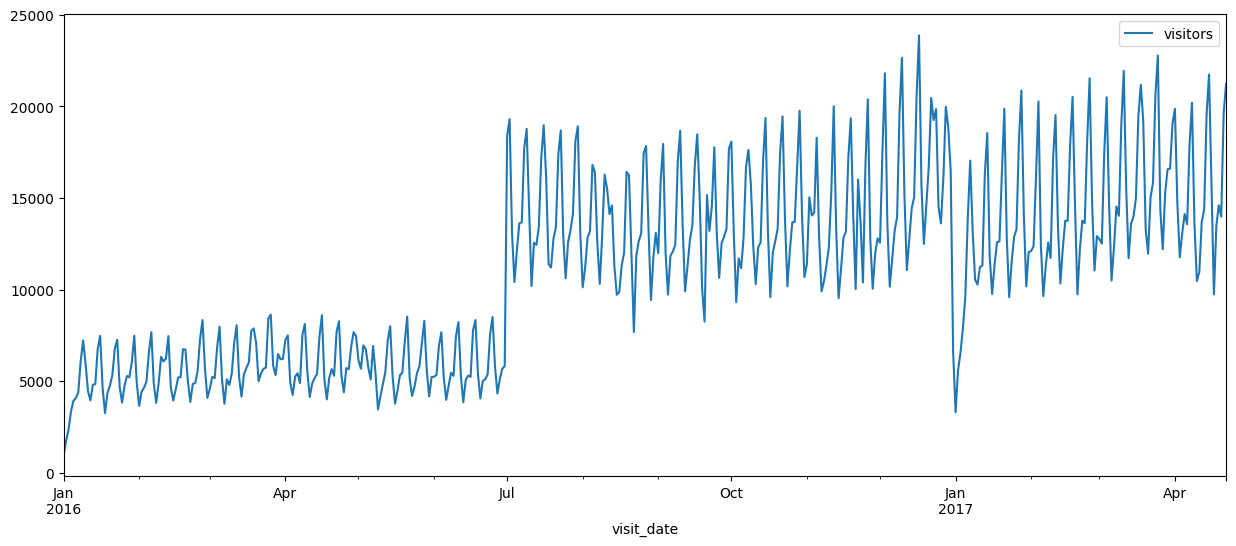

In [50]:
ts_visitors=visits_df_past.groupby(["visit_date"],as_index=False).agg({"visitors":np.sum})
ts_visitors=ts_visitors.set_index("visit_date")
ts_visitors.plot(figsize=(15,6))

In [51]:
visits_df.head()

,Dataset,id,air_store_id,visit_date,visitors,day_of_week,holiday_flg,weekend,Day_off,Tommorow_holiday,Yesterday_holiday
0,Past,air_ba937bf13d40fb24_2016-01-13,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,0,0,0,0
1,Past,air_25e9888d30b386df_2016-01-13,air_25e9888d30b386df,2016-01-13,21,Wednesday,0,0,0,0,0
2,Past,air_fd6aac1043520e83_2016-01-13,air_fd6aac1043520e83,2016-01-13,40,Wednesday,0,0,0,0,0
3,Past,air_64d4491ad8cdb1c6_2016-01-13,air_64d4491ad8cdb1c6,2016-01-13,5,Wednesday,0,0,0,0,0
4,Past,air_ee3a01f0c71a769f_2016-01-13,air_ee3a01f0c71a769f,2016-01-13,18,Wednesday,0,0,0,0,0


In [52]:
visits_df["jump_flag"]=visits_df['visit_date'].apply(lambda x:"1" if x.strftime("%Y-%m-%d")<"2016-07-01" else 0)
visits_df["jump_flag"].value_counts()

,count
jump_flag,
0,235199
1,47288


In [53]:
new_stores_plt=visits_df_past.groupby(['visit_date'], as_index=False).agg({"air_store_id":["count","size","nunique"]})
new_stores_plt.head()

visit_date air_store_id             
                    count size nunique
0 2016-01-01           46   46      46
1 2016-01-02           62   62      62
2 2016-01-03           80   80      80
3 2016-01-04          157  157     157
4 2016-01-05          230  230     230

Inference
* By looking at the time series plot, it is showing a hugr step up increase in the visits from july 2016 onwards.
* Overall there is an upward trend as well as seasonality in the visits.

####Visitors Distribution

Text(0.5, 0.98, 'Distribution of Visitors')

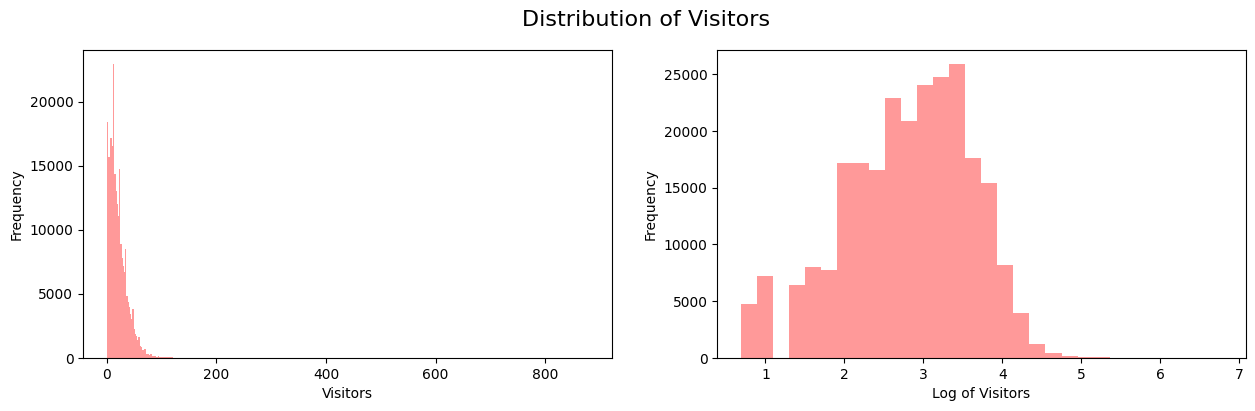

In [54]:
fig, ax=plt.subplots(1,2)
fig.set_size_inches(15,4,forward=True)

sns.distplot(visits_df_past['visitors'],kde=False,color='red',bins=400,ax=ax[0])
sns.distplot(np.log1p(visits_df_past['visitors']),kde=False, color='red',bins=30,ax=ax[1])

ax[0].set_xlabel('Visitors')
ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Log of Visitors')
ax[1].set_ylabel('Frequency')

fig.suptitle('Distribution of Visitors',fontsize=16)

In [56]:
# Median Visitors in a Day of a Week
median_day=visits_df_past.groupby(['day_of_week'],as_index=False).agg({'visitors':np.median})
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
mapp={day: i for i,day in enumerate(days)}
key=median_day['day_of_week'].map(mapp)
median_day=median_day.iloc[key.argsort()].set_index('day_of_week').reset_index()

#Median Visitors in Month of the Year
visits_df_past["Month"]=visits_df_past["visit_date"].apply(lambda x:)
